In [181]:
import pandas as pd
import numpy as np

import gensim
from gensim.models import word2vec
from sklearn.base import BaseEstimator, TransformerMixin

from tqdm import tqdm
tqdm.pandas()

from normalizer import normalize_sentences

## Предобработка данных

In [182]:
train_df = pd.read_csv('data/HeadHunter_train.csv', index_col=0)
test_df = pd.read_csv('data/HeadHunter_test.csv', index_col=0)

train_size = train_df.shape[0]

In [183]:
general_df = train_df.append(test_df).reset_index(drop=True)

In [184]:
general_text_columns = ['position', 'negative', 'positive']

In [243]:
import wordentropy.word_entropy
import importlib
word_entropy = importlib.reload(wordentropy.word_entropy)

from wordentropy.word_entropy import WordEntropyCounter

wec = WordEntropyCounter.from_file('wordentropy/english_russian_words.wec')

def text_entropy(text):
    entropy = 0
    
    for word in text.split():
        try: 
            entropy += wec.word_entropy(word)
        except:
            pass
        
    return entropy / len(text.split())

In [244]:
feature_pref_add = {
    'len': lambda col: general_df[col].str.len(),
    'words_count': lambda col: general_df[col].str.split().str.len(),
    'brakets_count': lambda col: abs(general_df[col].str.count('\)') - general_df[col].str.count('\(')),
    'three_points_count': lambda col: general_df[col].str.count('...') + general_df[col].str.count('…'),
    'digit_count': lambda col: general_df[col].str.count('[0-9]'),
    'vosk_count': lambda col: general_df[col].str.count('!') / general_df[col].str.len(),
    'non_ascii_dol': lambda col: general_df[col].str.count('[^a-zA-Zа-яА-Я]') / general_df[col].str.len(),
    'entropy': lambda col: general_df[col].apply(text_entropy),
    'max_length_word': lambda col: general_df[col].str.split().progress_apply(lambda x: max(len(t) for t in x))
}

In [245]:
word2replace = {
    'з/п': ' зарплата ',
    'з\\\\п': ' зарплата ',
    'зар.плат': ' зарплата ',
    'юр.лиц': ' юридическое лицо ',
    'физ.лиц': ' физическое лицо ',
    'ткрф': ' тк '
}

In [246]:
%%time
for col in general_text_columns:
    general_df[col] = general_df[col].fillna('None')
    general_df[col] = general_df[col].str.replace(',', ' , ')
    general_df[col] = general_df[col].str.replace('ё', 'е')
    general_df[col] = general_df[col].str.lower()
    
    for to_replace, replaced in word2replace.items():
        general_df[col] = general_df[col].str.replace(to_replace, replaced, regex=False)
    
    for pref, func in feature_pref_add.items():
        general_df[f'{col}_{pref}'] = func(col)

all_text_values = general_df[general_text_columns].fillna('None').to_numpy().flatten()

100%|███████████████████████████████| 101527/101527 [00:00<00:00, 256453.94it/s]


CPU times: user 43.7 s, sys: 491 ms, total: 44.2 s
Wall time: 44.4 s


In [189]:
# not_only_alpha_words = set()

# for text in all_text_values:
#     for word in text.split():
#         if '/' in word or '.' in word:
#             not_only_alpha_words.add(word)

In [190]:
clear_text_values = normalize_sentences(all_text_values)
all_text_values = [" ".join([word for word in text if len(word) >= 2]) for text in clear_text_values]

100%|███████████████████████████████| 304581/304581 [00:01<00:00, 210462.26it/s]


In [191]:
for i, col in enumerate(general_text_columns):
    general_df[f'normal_{col}'] = all_text_values[i::3]
    general_df[f'normal_{col}'] = general_df[f'normal_{col}'].replace('ё', 'е')

In [192]:
popular_cities = general_df.city.value_counts()[:50].index
general_df['city_cat'] = general_df.city.apply(lambda text: text if text in popular_cities else 'Другое')

In [247]:
train_df = general_df[:train_size].copy()
test_df = general_df[train_size:].copy()

train_df['target'] = train_df['target'].str.split(',')
train_df = train_df.explode('target')

train_df.drop(general_text_columns, axis=1).to_csv('data/clean_train.csv', index=False)
test_df.drop(general_text_columns, axis=1).to_csv('data/clean_test.csv', index=False)

In [248]:
# train_remove_indexes = train_df[train_df.positive.fillna('None').str.contains('commarystarkova')].index

In [249]:
# train_df = train_df.drop(train_remove_indexes)

In [317]:
train_df = pd.read_csv('data/clean_train.csv')
test_df = pd.read_csv('data/clean_test.csv')
train_df.drop([6672], inplace=True)
test_df.drop([6672], inplace=True)

<AxesSubplot:>

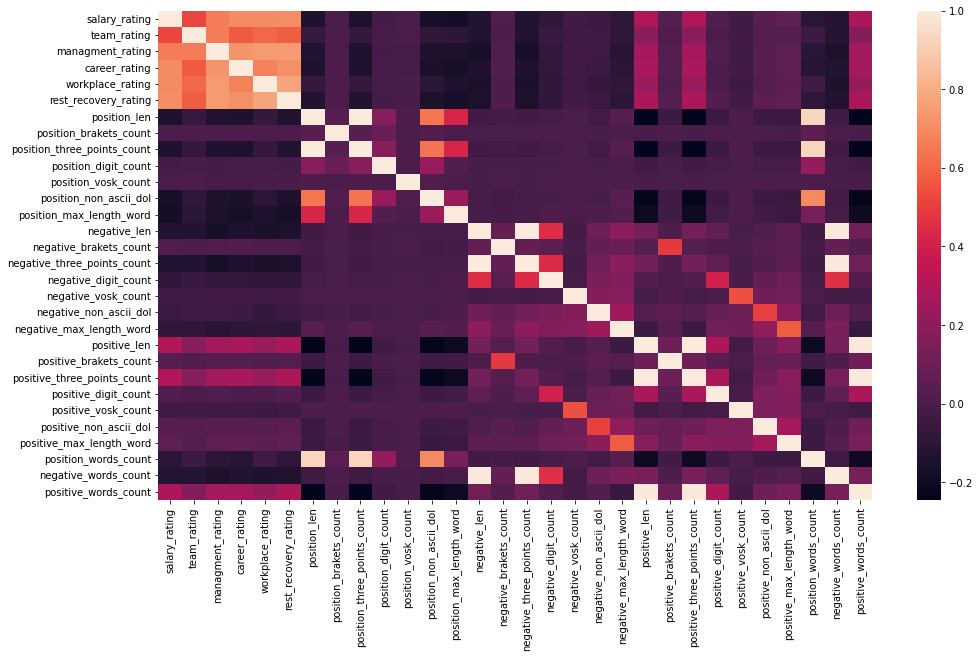

In [318]:
plt.figure(figsize=(16, 9))
sns.heatmap(train_df[real_columns].corr())

## Обучение моделей

In [319]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score

In [320]:
class SelectColumnsTransformer():
    def __init__(self, columns=None):
        self.columns = columns

    def transform(self, X, **transform_params):
        cpy_df = X[self.columns].copy()
        return cpy_df

    def fit(self, X, y=None, **fit_params):
        return self

In [321]:
class PandasSimpleImputer(SimpleImputer):
    """A wrapper around `SimpleImputer` to return data frames with columns.
    """

    def fit(self, X, y=None):
        self.columns = X.columns
        return super().fit(X, y)

    def transform(self, X):
        return pd.DataFrame(super().transform(X), columns=self.columns)

In [322]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")), 
        ("poly",  PolynomialFeatures(2)),
        ("scaler", StandardScaler())
    ]
)
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")), 
        ("encoder", OneHotEncoder(handle_unknown='ignore'))
    ]
)

def get_text_transformer(transformer):
    return Pipeline(
        steps=[
            ("imputer", PandasSimpleImputer(strategy="constant", fill_value='None')),
            ('transformer', ColumnTransformer([
                ('position', TfidfVectorizer(max_features=800, ngram_range=(1, 2)), 'normal_position'),
                *[
                (f"text_{col}", transformer, col)
                for col in text_columns
            ]]))
        ],
    )

In [323]:
from sklearn.svm import SVC, NuSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
import joblib

In [324]:
# Initializing Support Vector classifier
clf_svc = SVC(C = 50, degree = 1, gamma = "auto", kernel = "rbf", probability = True)

# Initializing Multi-layer perceptron  classifier
clf_mlp = MLPClassifier(activation = "relu", alpha = 0.1, hidden_layer_sizes = (10,10,10),
                            learning_rate = "constant", max_iter = 2000, random_state = 1000)

classifiers = [('svc', clf_svc),
               ('mlp', clf_mlp)]

In [325]:
stacked_model = StackingClassifier(
    estimators=classifiers, 
    final_estimator=LogisticRegression(),
    stack_method='auto',
    n_jobs=-1,
    passthrough=False
)

In [326]:
def pipe_with_text_transformer(text_transformer, clf_model):
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, real_columns),
            ("cat", categorical_transformer, cat_columns),
            ("text", text_transformer, text_columns + ['normal_position']),
        ],
        transformer_weights={
            'num': 1,
            'cat': 1,
            'text': 2,
        }
    )
    
    pipe = Pipeline(steps=[
        ('transformer', preprocessor),
        ('model', clf_model)
    ])
    
    return pipe

In [327]:
target = 'target'
exception = ['review_id', target, 'positive_entropy', 'negative_entropy', 'position_entropy']
real_columns = [col for col in train_df.columns if col not in exception and not isinstance(train_df.iloc[0][col], str)]
cat_columns = ['city']
text_columns = ['normal_positive', 'normal_negative']

In [328]:
import seaborn as sns
import matplotlib.pyplot as plt

In [329]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df.drop(target, axis=1), 
    train_df[target], 
    test_size=0.05, 
    random_state=42
)

In [330]:
import nltk
from nltk.corpus import stopwords
stopwords = stopwords.words('russian')

In [331]:
def test_pipe(pipe):
    y_pred = pipe.predict(X_test)
    
    print('f1_score:', f1_score(y_test, y_pred, average='weighted'))
    print('accuracy:', accuracy_score(y_test, y_pred))
    
def sumbit(pipe):
    sub_df = pd.read_csv('data/HeadHunter_sample_submit.csv')
    submittions = pipe.predict(test_df)
    sub_df['target'] = submittions
    return sub_df.to_csv('submittion.csv', index=False)

### TF-IDF

In [332]:
tfidf_text_transformer = get_text_transformer(
    TfidfVectorizer(
        max_features=1000,
    )
)
tfidf_pipe = pipe_with_text_transformer(tfidf_text_transformer, LogisticRegression())

In [333]:
%%time
tfidf_pipe = tfidf_pipe.fit(X_train, y_train)

CPU times: user 1min 42s, sys: 12.3 s, total: 1min 54s
Wall time: 41.7 s


/Users/michil/.virtualenvs/base/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [334]:
test_pipe(tfidf_pipe)  # 76.61

f1_score: 0.7588078827523054
accuracy: 0.7749255952380952


In [295]:
feature_extractor = tfidf_pipe.named_steps['transformer']
joblib.dump(feature_extractor, 'feature_extractor.joblib')

['feature_extractor.joblib']

In [654]:
joblib.dump(tfidf_pipe, 'models/tfidf_pipe_0.76305.joblib')

['models/tfidf_pipe_0.76305.joblib']

In [19]:
# sumbit(tfidf_pipe)

### Word2Vec

In [107]:
class HHWord2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model
        self.emb_size = model.vector_size
    
    def text2vec(self, text):
        vector = np.array([.0 for _ in range(self.emb_size)])
        count = 0

        for word in text.split():
            if word in self.model.wv:
                vector += self.model.wv[word]
                count += 1

        if count != 0:
            vector /= count

        return vector

    def fit(self,X, y=None):
        return self
    
    def transform(self, X, y=None): 
        vectors = np.zeros((X.shape[0], self.emb_size))
        
        for i, text in tqdm(enumerate(X), total=len(X)):
            vectors[i, :] = self.text2vec(text)
            
        return vectors

In [108]:
model = gensim.models.Word2Vec.load('hh_word2vec.pickle')

In [109]:
word2vec_transformer = get_text_transformer(HHWord2VecTransformer(model))
word2vec_pipe = pipe_with_text_transformer(word2vec_transformer, LogisticRegression())

In [110]:
%%time
word2vec_pipe.fit(X_train, y_train);

100%|███████████████████████████████████| 51065/51065 [00:06<00:00, 7490.17it/s]


CPU times: user 1min 9s, sys: 2.52 s, total: 1min 12s
Wall time: 32.8 s


/Users/michil/.virtualenvs/base/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformer_weights={'cat': 1, 'num': 1,
                                                        'text': 2},
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['salary_rating',
                                                   'team_rating',
                                                   'managment_rating',
                                                   '

In [111]:
y_pred = word2vec_pipe.predict(X_test)

print('f1_score:', f1_score(y_test, y_pred, average='weighted')) # 0.729
print('accuracy_score:', accuracy_score(y_test, y_pred))

100%|█████████████████████████████████████| 2688/2688 [00:00<00:00, 7842.08it/s]


f1_score: 0.8818391266791821
accuracy_score: 0.8828125


In [665]:
word2vec_feature_extractor = word2vec_pipe.named_steps['transformer']

In [666]:
joblib.dump(word2vec_feature_extractor, 'word2vec_feature_extractor.joblib')

['word2vec_feature_extractor.joblib']

In [377]:
sumbit(word2vec_pipe)

100%|██████████████████████████████████| 50651/50651 [00:04<00:00, 12274.51it/s]


In [430]:
# joblib.dump(word2vec_pipe, 'models/word2vec_pipe_0.729.pickle')

['models/word2vec_pipe_0.729.pickle']

### Preindexed BERT

In [138]:
np.array([x for x in [[1, 2], [3, 4]]])

array([[1, 2],
       [3, 4]])

In [170]:
class BertVectTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, positive_vectors, negative_vectors):
        self.positive_vectors = positive_vectors
        self.negative_vectors = negative_vectors

    def fit(self,X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.array([
            self.positive_vectors[X.index[i]]
            if X.name == 'normal_positive'
            else
            self.negative_vectors[X.index[i]]
            for i in range(X.shape[0])
        ])

In [171]:
X_train.normal_positive.index[0]

47147

In [ ]:
import torch

In [335]:
vectors = joblib.load('n_sentences.joblib')

In [336]:
position_vectors = vectors[::3]
negative_vectors = vectors[1::3]
positive_vectors = vectors[2::3]

In [337]:
# test_df.index += train_df.shape[0]

In [338]:
bert_transformer = get_text_transformer(BertVectTransformer(positive_vectors, negative_vectors))
bert_pipe = pipe_with_text_transformer(bert_transformer, LogisticRegression())

In [ ]:
%%time
bert_pipe.fit(X_train, y_train);

normal_positive
normal_negative


In [ ]:
test_pipe(bert_pipe)

In [176]:
feature_extractor = bert_pipe.named_steps['transformer']